<a href="https://colab.research.google.com/github/esuda/mineiracao_dados_complexos/blob/master/Copy_of_C%C3%B3pia_de_Trabalho2_ISIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho 2: Transfer Learning


## Carregamento dos dados

Os .zips contendo o dataset está no google drive. O código abaixo faz o download, e extrai o zip. Note que você precisará logar no Google para que esse processo seja possível. Caso haja alguma falha ou erro no processo, reinicie o notebook, e tente novamente.

Depois desse processo, teremos no diretório:

*   isic2017-train: 2000 imagens. 
*   isic2017-val: 150 imagens.
*   isic2017-test: 650 imagens.



In [1]:
!pip install PyDrive &> /dev/null

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1EH2tlRi4Iqq8WfLOXl6hMc5jTeiIRzaW"})
downloaded.GetContentFile('isic2017-trainval.zip')
!unzip -q isic2017-trainval.zip

downloaded = drive.CreateFile({'id':"1uP1tCj6-T2FXxk7g7gqoC_SGOhqIQyrM"})   
downloaded.GetContentFile('isic2017-test.zip')       
!unzip -q isic2017-test.zip

In [3]:
!ls -1 isic2017-train/malignant | wc -l 

374


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
ls

adc.json  isic2017-test/     isic2017-train/        isic2017-val/
drive/    isic2017-test.zip  isic2017-trainval.zip  sample_data/


Em cada diretório, temos uma pasta contendo as lesões benignas ('/benign') e outra contendo as lesões malignas ('/malignant'). A separação dessa forma facilita a importação dos dados utilizando o keras.
Estude o uso da ImageDataGenerator do Keras, pois ela facilita o uso de aumentação e pré-processamento dos dados.


## Classes / funções de apoio

In [6]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
import pandas as pd
from matplotlib import image
class RocCallback(Callback):
    def __init__(self,training_data,validation_data):
        # training
        batch_index = 0
        while batch_index <= training_data.batch_index:
            img, label = training_data.next()
            if batch_index ==0:
              img_list = img
              label_list = label
            else:
              img_list = np.concatenate((img_list, img), axis=0)
              label_list = np.concatenate((label_list, label), axis=0)
            batch_index = batch_index + 1
        self.x = img_list
        self.y = label_list

        # validation
        batch_index = 0
        while batch_index <= validation_data.batch_index:
            img, label = validation_data.next()
            if batch_index ==0:
              img_list = img
              label_list = label
            else:
              img_list = np.concatenate((img_list, img), axis=0)
              label_list = np.concatenate((label_list, label), axis=0)
            batch_index = batch_index + 1
        self.x_val = img_list
        self.y_val = label_list


    def on_epoch_end(self, epoch, logs={}):
        y_pred_train = self.model.predict(self.x)
        print("SHAPE", y_pred_train.shape)
        roc_train = roc_auc_score(self.y[:,1], y_pred_train[:,1])
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val[:,1], y_pred_val[:,1])
        logs["train_auc"] = roc_val
        logs["val_auc"] = roc_val
        keys = list(logs.keys())
        print('\rroc-auc_train: %s - roc-auc_val: %s' % (str(round(roc_train,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return



In [7]:
def plotImages(imgList, n_row=1, n_col=1):
    _, axs = plt.subplots(n_row, n_col, figsize=(3, 3))
    axs = axs.flatten()
    for img, ax in zip(imgList, axs):
        ax.imshow(np.uint8(img), interpolation='nearest')
    plt.show()
        
        
def plotImage(img):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)

    ax.imshow(np.uint8(img), interpolation='nearest')
    plt.show()

In [8]:
ls

adc.json  isic2017-test/     isic2017-train/        isic2017-val/
drive/    isic2017-test.zip  isic2017-trainval.zip  sample_data/


In [9]:
import os

In [10]:
def ret_class(filepath:str)->str:
  return filepath.split('/')[2]

In [11]:
def ret_df(df_path:str)->pd.DataFrame:
  dataset_path = df_path
  lst_path = []
  #lst_nd_array_img = []
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
    for f in filenames:
      
      lst_path.append(dirpath + '/' + f )
      #lst_nd_array_img.append(image.imread(dirpath + '/' + f))
  #df_path_test = pd.DataFrame({'filepath':lst_path,'img':lst_nd_array_img})
  df_path = pd.DataFrame({'filepath':lst_path})
  df_path['class'] = df_path['filepath'].apply(ret_class)
  return df_path


In [12]:
ls

adc.json  isic2017-test/     isic2017-train/        isic2017-val/
drive/    isic2017-test.zip  isic2017-trainval.zip  sample_data/


In [13]:
df_train = ret_df('./isic2017-train')
df_val = ret_df('./isic2017-val')
df_test = ret_df('./isic2017-test')

In [14]:
df_test

,filepath,class
0,./isic2017-test/malignant/ISIC_0015119.png,malignant
1,./isic2017-test/malignant/ISIC_0013953.png,malignant
2,./isic2017-test/malignant/ISIC_0014319.png,malignant
3,./isic2017-test/malignant/ISIC_0013988.png,malignant
4,./isic2017-test/malignant/ISIC_0015193.png,malignant
...,...,...
595,./isic2017-test/benign/ISIC_0015481.png,benign
596,./isic2017-test/benign/ISIC_0016068.png,benign
597,./isic2017-test/benign/ISIC_0013169.png,benign
598,./isic2017-test/benign/ISIC_0015015.png,benign


## Gerando Dados com ImageDataGenerator

In [15]:
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=45
)



train_generator = train_datagen.flow_from_directory(
    'isic2017-train/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory('isic2017-val/',
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='categorical',
                                                         shuffle=False)



original_train_datagen =tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=None,
                                                                        rescale=1/255.)

original_train_generator = original_train_datagen.flow_from_directory('isic2017-train/',
                                                                      target_size=(224, 224),
                                                                      batch_size=32,
                                                                      class_mode='categorical',
                                                                      shuffle=True)


Found 2000 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [16]:
import tensorflow as tf

In [17]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [18]:
df_train

,filepath,class
0,./isic2017-train/malignant/ISIC_0014072.png,malignant
1,./isic2017-train/malignant/ISIC_0000521.png,malignant
2,./isic2017-train/malignant/ISIC_0013258.png,malignant
3,./isic2017-train/malignant/ISIC_0000172.png,malignant
4,./isic2017-train/malignant/ISIC_0014133.png,malignant
...,...,...
1995,./isic2017-train/benign/ISIC_0011372.png,benign
1996,./isic2017-train/benign/ISIC_0010060.png,benign
1997,./isic2017-train/benign/ISIC_0009583.png,benign
1998,./isic2017-train/benign/ISIC_0013092.png,benign


In [19]:
BATCH_SIZE = 32
NUM_CLASSES = 2
train_generator = train_datagen.flow_from_dataframe(dataframe = df_train,
                                                    directory='./',
                                                    x_col = 'filepath',
                                                    y_col = 'class',
                                                    subset = 'training',
                                                    batch_size=BATCH_SIZE,    
                                                    target_size=(224, 224),                                                   
                                                    class_mode='sparse',
                                                    shuffle=False)



Found 2000 validated image filenames belonging to 2 classes.


In [20]:
pd.DataFrame({'classes':train_generator.classes}).value_counts()/len(pd.DataFrame({'classes':train_generator.classes}))

classes
0          0.813
1          0.187
dtype: float64

In [21]:
a = 1626
b = 374

In [22]:
b*1.5/(a*0.70+b*1.5)

0.33015536723163846

In [23]:
b*2.6738/(a*0.615+b*2.6738)

0.50000280001232

## Verificando desbanceamento

In [24]:
#treino
pd.DataFrame(train_generator.classes, columns = ['y']).value_counts()/2000

y
0    0.813
1    0.187
dtype: float64

In [25]:
#validação
pd.DataFrame(validation_generator.classes, columns = ['y']).value_counts()/150

y
0    0.8
1    0.2
dtype: float64

In [26]:
from matplotlib import image
def plot_img(index:int, dataset:np.ndarray)->None:
  plt.figure(figsize = (3,3))
  plt.imshow(dataset[index])
  plt.title('index - {}'.format(index))
  
def plot_4_batch_img(lst_img, np_array):
  plt.figure(figsize=(9,4))

  plt.subplot(141)
  n = lst_img[0]
  plt.imshow(np_array[n])
  plt.title('index = {}'.format(n))
  plt.subplot(142)
  n = lst_img[1]
  plt.imshow(np_array[n])
  plt.title('index = {}'.format(n))
  plt.subplot(143)
  n = lst_img[2]
  plt.imshow(np_array[n] )
  plt.title('index = {}'.format(n))
  plt.subplot(144)
  n = lst_img[3]
  plt.imshow(np_array[n])
  plt.title('index = {}'.format(n))

  plt.tight_layout()




In [27]:
#plt.imshow(image.imread('./isic2017-train/benign/ISIC_0000000.png'))

# 1. Aplique aumentação de dados nas imagens, escolhendo três transformações.
 Mostre exemplos das transformações escolhidas e justifique porquê elas são válidas neste dataset.


## Figuras Originais

In [28]:
original_train_generator.reset()
X_train_orig_b_0, y_train_orig_b_0 = original_train_generator.next()

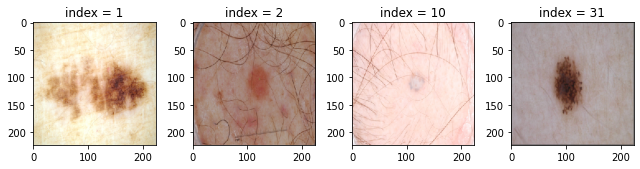

In [29]:
plot_4_batch_img([1,2,10,31], X_train_orig_b_0)

## 1.1 Verificando Transformações Baseline 
Transformações dadas pelo notebook

In [30]:
train_generator.reset()
X_train_b_0, y_train_b_0 = train_generator.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


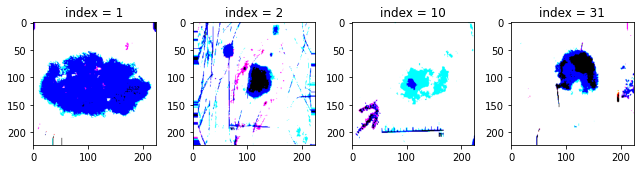

In [31]:
plot_4_batch_img([1,2,10,31],X_train_b_0 )

* Quando tem outlier causa uma figura com muito preto que pode alterar a forma de percepção do classificador *
* o pré-processamento das imagens diminui o ruido com o fundo e esta dando uma melhorada onde tem textura diferentes

## 1.2 - Criando Aumentação de dados

Itens que podem melhorar a geração de imagens
* Zoom
* Tamanho
* Largura
* Altura
* Brilho
* rotação
* fundo (*)



In [32]:
train_datagen_m = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255.,        
        width_shift_range=[0.9, 1.1],
        height_shift_range=[0.9, 1.1],
        zoom_range=[0.9,1.1],
        rotation_range = 45,
        brightness_range=[0.5,1.5],
        horizontal_flip=True)

test_datagen_m  = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=45, rescale=1./255.) # não entendi o pq do rotation



train_generator_m  = train_datagen_m.flow_from_directory('isic2017-train/',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    shuffle=False)

validation_generator_m  = train_datagen_m.flow_from_directory('isic2017-val/',
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='categorical',
                                                         shuffle=False)

Found 2000 images belonging to 2 classes.
Found 150 images belonging to 2 classes.


In [33]:
#b = batch
#0 = n_batch
train_generator_m.reset()
X_train_b_0_m, y_train_b_0_m = train_generator_m.next()

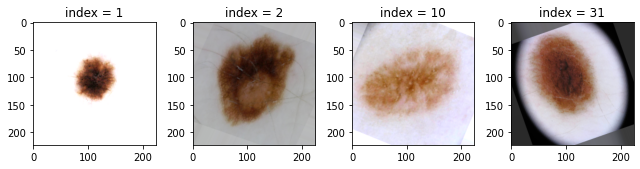

In [34]:
plot_4_batch_img([1,2,10,31],X_train_b_0_m )

A rotação não aparenta ser uma boa ideia, a imagem com preenchimento podem confundir o classificador

In [35]:
train_datagen_m = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255.,        
        width_shift_range=[0.9, 1.1],
        height_shift_range=[0.9, 1.1],
        zoom_range=[0.9,1.1],
        brightness_range=[0.5,1.5],
        horizontal_flip=True)

test_datagen_m  = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=45, rescale=1./255.) # não entendi o pq do rotation



train_generator_m  = train_datagen_m.flow_from_directory('isic2017-train/',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    shuffle=False)

validation_generator_m  = train_datagen_m.flow_from_directory('isic2017-val/',
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='categorical',
                                                         shuffle=False)

Found 2000 images belonging to 2 classes.
Found 150 images belonging to 2 classes.


In [36]:
#b = batch
#0 = n_batch
train_generator_m.reset()
X_train_b_0_m, y_train_b_0_m = train_generator_m.next()

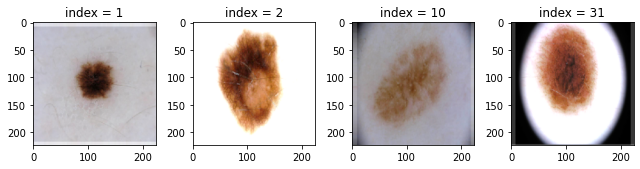

In [37]:
plot_4_batch_img([1,2,10,31],X_train_b_0_m )

In [ ]:
#Interessante se houvesse um pré processamento para retirar a imagem do fundo 

# 2. Como baseline, construa e treine um modelo convolucional simples. Discuta o resultado

In [38]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, Dense, Flatten, Dropout,
    GlobalMaxPooling2D, MaxPooling2D, BatchNormalization, MaxPool2D
)

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras.layers.merge import concatenate
from tensorflow.keras.utils import plot_model

from sklearn.metrics import (
    confusion_matrix, classification_report,
    balanced_accuracy_score
)
np.set_printoptions(precision=4,suppress=True)

In [39]:
X_train_b_0_m[0].shape

(224, 224, 3)

## 2.1 Baseline Vanilla

### 2.1.1 - Sem Balanceamento

In [40]:
auc_metric = tf.keras.metrics.AUC(
    num_thresholds=200,
    curve="ROC",
    summation_method="interpolation",
    name=None,
    dtype=None,
    thresholds=None,
    multi_label=False,
    num_labels=None,
    label_weights=None,
    from_logits=False,
)


In [41]:
# Rede Neural Vanilla
model_baseline = Sequential()
#Camada convolucional com 32 filtros de tamanho 3x3 
model_baseline.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=(224, 224, 3)))
#Max pooling de tamanho 2x2
model_baseline.add(MaxPooling2D(pool_size=(2,2)))
#Operação de vetorização dos dados
model_baseline.add(Flatten())
#Densa com 10 nós de saída
model_baseline.add(Dense(2,activation='softmax'))

model_baseline.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[auc_metric])

model_baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 802818    
Total params: 803,714
Trainable params: 803,714
Non-trainable params: 0
_________________________________________________________________


In [ ]:
filepath="baseline_vanilla.h5"


checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_auc',patience=10)

roc_cb = RocCallback(train_generator_m, validation_generator_m)
callback_list = [checkpoint,early_stop,roc_cb ]
batch_size = 32

steps_per_epoch = 2000 // batch_size



history_model_baseline= model_baseline.fit(train_generator_m,steps_per_epoch=steps_per_epoch,
                                                    epochs = 64, batch_size = batch_size,                                        
                                                    validation_data= validation_generator_m,
                                                    callbacks=callback_list,)

Epoch 1/64


In [ ]:
model_baseline.load_weights('./baseline_vanilla.h5')
predicts_model_baseline_val = np.argmax(model_baseline.predict(validation_generator_m), axis = 1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(validation_generator_m.classes, predicts_model_baseline_val))

              precision    recall  f1-score   support

           0       0.80      0.99      0.88       120
           1       0.00      0.00      0.00        30

    accuracy                           0.79       150
   macro avg       0.40      0.50      0.44       150
weighted avg       0.64      0.79      0.71       150



### 2.1.2 - Baseline vanilla Com Balanceamento por pesos

In [ ]:
from sklearn.utils import class_weight

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train_generator_m.classes),
                                                  train_generator_m.classes)

In [ ]:
class_weights

array([0.615 , 2.6738])

In [ ]:
# Rede Neural Vanilla
model_baseline = Sequential()
#Camada convolucional com 32 filtros de tamanho 3x3 
model_baseline.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=(224, 224, 3)))
#Max pooling de tamanho 2x2
model_baseline.add(MaxPooling2D(pool_size=(2,2)))
#Operação de vetorização dos dados
model_baseline.add(Flatten())
#Densa com 10 nós de saída
model_baseline.add(Dense(2,activation='softmax'))

model_baseline.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[auc_metric])

model_baseline.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 401408)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 802818    
Total params: 803,714
Trainable params: 803,714
Non-trainable params: 0
_________________________________________________________________


In [ ]:
filepath="baseline_vanilla_2.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_auc',patience=10)
roc_cb = RocCallback(train_generator_m, validation_generator_m)


callback_list = [checkpoint,early_stop,roc_cb ]
batch_size = 32
#data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
#train_generator = data_generator.flow(x_train, y_train_f, batch_size)
steps_per_epoch = 2000 // batch_size



history_model_baseline= model_baseline.fit(train_generator_m,
                                           steps_per_epoch=steps_per_epoch,
                                           epochs = 64, batch_size = batch_size,                                        
                                           validation_data= validation_generator_m,
                                           class_weight = {0:0.615,
                                                           1: 2.6738},
                                           callbacks=callback_list  )

Epoch 1/64
62/62 [==============================] - 35s 551ms/step - loss: 13.8214 - auc: 0.4140 - val_loss: 0.8848 - val_auc: 0.3279

Epoch 00001: val_auc improved from -inf to 0.32791, saving model to baseline_vanilla_2.h5
SHAPE (2000, 2)
roc-auc_train: 0.5656 - roc-auc_val: 0.6606                                                                                                    
Epoch 2/64
62/62 [==============================] - 33s 539ms/step - loss: 1.1270 - auc: 0.4116 - val_loss: 0.5126 - val_auc: 0.8162

Epoch 00002: val_auc improved from 0.32791 to 0.81618, saving model to baseline_vanilla_2.h5
SHAPE (2000, 2)
roc-auc_train: 0.562 - roc-auc_val: 0.5008                                                                                                    
Epoch 3/64
62/62 [==============================] - 34s 543ms/step - loss: 0.9146 - auc: 0.5375 - val_loss: 0.8166 - val_auc: 0.3236

Epoch 00003: val_auc did not improve from 0.81618
SHAPE (2000, 2)
roc-auc_train: 0.5628 - roc-a

InternalError: ignored

In [ ]:
model_baseline.load_weights('./baseline_vanilla_2.h5')
predicts_model_baseline_val = np.argmax(model_baseline.predict(validation_generator_m), axis = 1)

In [ ]:
print(classification_report(validation_generator_m.classes, predicts_model_baseline_val))

Modificar a forma de metrica, se colocar acuracia se ele bater 80% pode ser que chutou tudo de 1 classe só 

## 2.2 Baseline Skw

In [ ]:
model_skw_03 = Sequential()


# 1- set
# CONV 
model_skw_03.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(224, 224, 3),padding='same' ,activation='relu',))
# NORM
model_skw_03.add(BatchNormalization())
# CONV 
model_skw_03.add(Conv2D(filters=32, kernel_size=(3,3),padding='same', activation='relu',))
# NORM
model_skw_03.add(BatchNormalization())
# POOLING LAYER
model_skw_03.add(MaxPool2D(pool_size=(2, 2)))


# 2- set
model_skw_03.add(Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu',))
# NORM
model_skw_03.add(BatchNormalization())
# CONV 
model_skw_03.add(Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu',))
# NORM
model_skw_03.add(BatchNormalization())
# POOLING LAYER
model_skw_03.add(MaxPool2D(pool_size=(2, 2)))

# 3 - set

model_skw_03.add(Conv2D(filters=128, kernel_size=(3,3),padding='same', activation='relu',))
# NORM
model_skw_03.add(BatchNormalization())
# CONV 
model_skw_03.add(Conv2D(filters=128, kernel_size=(3,3),padding='same', activation='relu',))
# NORM
model_skw_03.add(BatchNormalization())
# POOLING LAYER
model_skw_03.add(MaxPool2D(pool_size=(2, 2)))


# 4 - set bottleneck

model_skw_03.add(Conv2D(filters=64, kernel_size=(1,1),padding='same', activation='relu',))
# NORM
model_skw_03.add(BatchNormalization())
# CONV 
model_skw_03.add(Conv2D(filters=32, kernel_size=(3,3),padding='same', activation='relu',))
# NORM
model_skw_03.add(BatchNormalization())
# POOLING LAYER
model_skw_03.add(MaxPool2D(pool_size=(2, 2)))


# 4- FC
model_skw_03.add(Flatten())
#sem sentido esse dropout
model_skw_03.add(Dropout(0.2))
# DENSE 01
model_skw_03.add(Dense(1024, activation='relu'))

model_skw_03.add(Dropout(0.2))
# DENSE 02
model_skw_03.add(Dense(2, activation='softmax'))


model_skw_03.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=[auc_metric])
model_skw_03.summary()
#plot_model(model_skw_03, show_shapes=True )

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 64)     

In [ ]:
filepath="mode_skw3_bottleneck.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_auc',patience=100)
#roc_cb = RocCallback(train_generator_m, validation_generator_m)


callback_list = [checkpoint,early_stop]#,roc_cb ]
batch_size = 32
#data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
#train_generator = data_generator.flow(x_train, y_train_f, batch_size)
steps_per_epoch = 2000 // batch_size



history_model_skw_03= model_skw_03.fit(train_generator_m,
                                           steps_per_epoch=steps_per_epoch,
                                           epochs = 256, batch_size = batch_size,                                        
                                           validation_data= validation_generator_m,
                                           class_weight = {0:0.615,
                                                           1: 2.6738},
                                           callbacks=callback_list  )

Epoch 1/256
62/62 [==============================] - 35s 569ms/step - loss: 0.6868 - auc: 0.5552 - val_loss: 0.8257 - val_auc: 0.5974

Epoch 00001: val_auc improved from -inf to 0.59740, saving model to mode_skw3_bottleneck.h5
Epoch 2/256
62/62 [==============================] - 35s 558ms/step - loss: 0.6978 - auc: 0.4934 - val_loss: 0.6791 - val_auc: 0.6340

Epoch 00002: val_auc improved from 0.59740 to 0.63400, saving model to mode_skw3_bottleneck.h5
Epoch 3/256
62/62 [==============================] - 34s 552ms/step - loss: 0.7747 - auc: 0.6483 - val_loss: 0.6098 - val_auc: 0.7342

Epoch 00003: val_auc improved from 0.63400 to 0.73416, saving model to mode_skw3_bottleneck.h5
Epoch 4/256
62/62 [==============================] - 34s 545ms/step - loss: 0.6951 - auc: 0.5600 - val_loss: 0.7511 - val_auc: 0.5589

Epoch 00004: val_auc did not improve from 0.73416
Epoch 5/256
62/62 [==============================] - 34s 543ms/step - loss: 0.6428 - auc: 0.6092 - val_loss: 0.6432 - val_auc: 0

KeyboardInterrupt: ignored

In [ ]:
model_skw_03.load_weights('./mode_skw3_bottleneck.h5')
predicts_model_skw_03 = np.argmax(model_skw_03.predict(validation_generator_m), axis = 1)

In [ ]:
print(classification_report(validation_generator_m.classes, predicts_model_skw_03))

              precision    recall  f1-score   support

           0       0.82      0.96      0.88       120
           1       0.44      0.13      0.21        30

    accuracy                           0.79       150
   macro avg       0.63      0.55      0.54       150
weighted avg       0.74      0.79      0.75       150



In [ ]:
confusion_matrix(validation_generator_m.classes, predicts_model_skw_03)

array([[115,   5],
       [ 26,   4]])

# 3. Escolha uma arquitetura cuja implementação e pesos pré-treinados na ImageNet estejam disponíveis como extratora de features. Compare com o baseline e discuta os resultado

# 4. Inicialmente, descarte a saída original e congele suas as camadas.
 Adicione uma nova camada de
saída com o número de classes adequadas para este problema. Compare com os resultados anteriores
e discuta os resultados.


#5. Descongele as camadas da rede extratora de features e realize o fine-tuning da rede, continuando o treinamento.
 Compare com os resultados anteriores e discuta os resultados

# 6. Avalie o melhor modelo no conjunto de teste. 
Compare com os resultados anteriores e discuta
os resultados. Quais foram as conclusões?

## Treine e avalie o modelo

In [ ]:
roc = RocCallback(training_data=train_generator,
                  validation_data=validation_generator)
# Para verificar a AUC depois de cada época, inclua 'roc' em callbacks do método fit.
# Exemplo:
#history = model.fit(train_generator, epochs=50, callbacks=[roc], validation_data=validation_generator)
